# Computer vision application with torchvision

In [248]:
DEVICE, FORCE_CPU = "cpu", False
if not FORCE_CPU and torch.backends.mps.is_available():
    DEVICE="mps"
elif not FORCE_CPU and torch.cuda.is_available():
    DEVICE="cuda"
DEVICE

'mps'

## Import dependencies

In [249]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
# from torchvision import transforms
# from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

### Import dataset from torchvision
We are using FashionMNIST

In [250]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor(),
    target_transform=None
)

### Data inspection
Find out more about the dataset that we are using

You can inspect the attributes of the class by just typing `train_data.` and see what comes up

In [251]:
len(train_data), len(test_data)

(60000, 10000)

In [252]:
# See the first training example
print(type(train_data[0])) # Tuple
print(len(train_data[0])) # length 2
image, label = train_data[0]
print(f"image.shape={image.shape}") # (1,28,28)
# Each image is 28x28 and only has 1 color channel because it is grayscale
print(f"label={label}")

<class 'tuple'>
2
image.shape=torch.Size([1, 28, 28])
label=9


In [253]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [254]:
# Returns an enumerated dict of the class list
class_to_idx = train_data.class_to_idx
class_to_idx

{'T-shirt/top': 0,
 'Trouser': 1,
 'Pullover': 2,
 'Dress': 3,
 'Coat': 4,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'Bag': 8,
 'Ankle boot': 9}

We now know that input is a 28x28 grayscale image that's encoded as a tuple, and output that ranges from 0-9 which represents a class/category that the image falls into

## Visualize the data

Running `plt.imshow(image)` returns an error because mpl expects the image channel to come last. Therefore, **we have to remove that dimension when plotting**

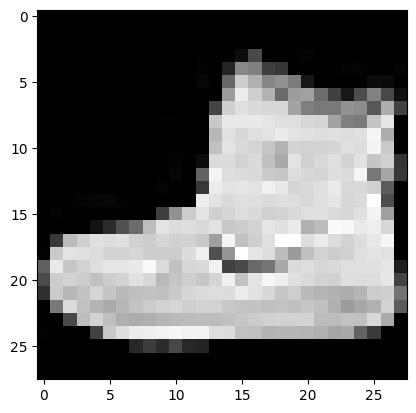

In [255]:
plt.imshow(image.squeeze(), cmap='gray') # .squeeze removes the extra dimension of size 1

### A common pattern when it comes to inspecting data:

#### 1) Generate some kind of random index using 
```python
rand_idx = torch.randint(start, end, size=(1,)).item()
```
`size=[1]` or `size=(1,)` parameter specifies the size of the output tensor as a tuple, and `.item()` returns the only item in a tensor of size 1 (turns tensor into value)

#### 2) Index an instance of training data (X, y) to the random index in the overall dataset
`X, y = training_data[rand_idx]`

#### 3) Display using pyplot
`plt.imshow(X.squeeze(), cmap=gray)` and title being `plt.title(class_names[y])`

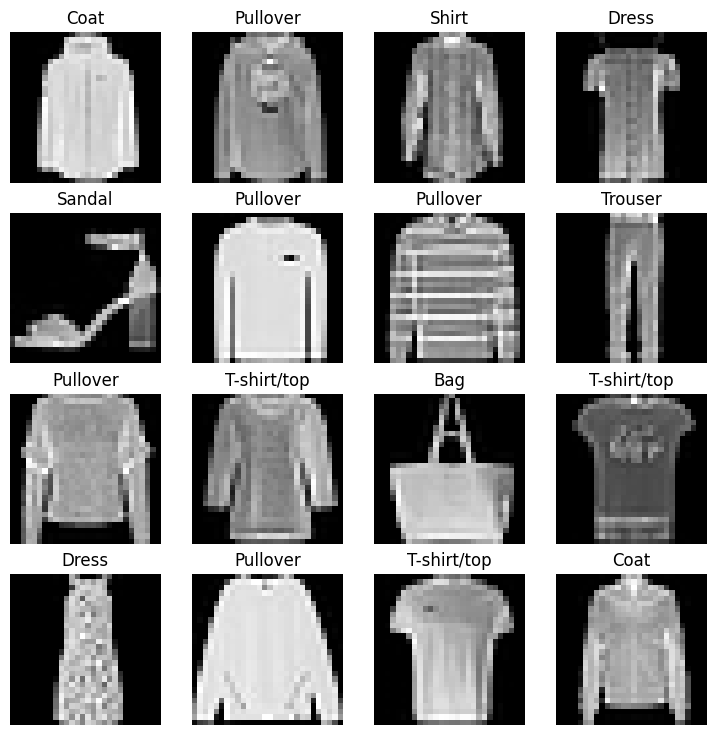

In [256]:
# Plot more images
torch.manual_seed(1001)
fig = plt.figure(figsize=(9,9))
rows, cols= 4, 4
for i in range(1,rows*cols+1):
    rand_idx = torch.randint(0,len(train_data),size=(1,)).item()
    img, label = train_data[rand_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(class_names[label]) # access the name of class based on train_data.class_to_idx dict provided
    plt.axis(False)

# Preparing a DataLoader
Right now, our data is in the form of a dataset.
DataLoader turns our dataset into a Python iterable.
In particular, we want to turn our data into *batches/minibatches*.

Why?

1. For large datasets, it is not feasible to load the entire dataset into memory at a single go especially when the dataset becomes bigger and images become more detailed. So we brek it down into mini-batches

2. It gives the neural network more changes to update its gradients per epoch (watch mini batch gradient descent by andrew ng)

In [257]:
from torch.utils.data import DataLoader

In [258]:
BATCH_SIZE = 32

In [259]:
train_dl = DataLoader(
    dataset=train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
    )
test_dl = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # there's no need to shuffle data here.
    )

In [260]:
# Inspect a training dataloader
train_features_batch, train_labels_batch = next(iter(train_dl))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

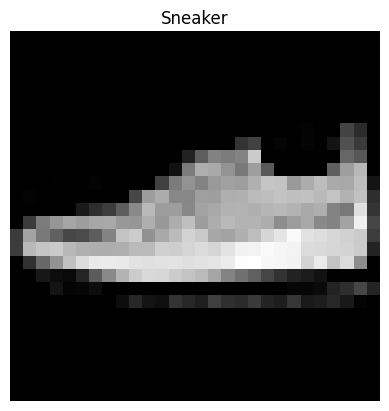

In [261]:
# show a sample
# torch.manual_seed(22)
rand_idx = torch.randint(0,BATCH_SIZE, size=[1]).item()
img, label = train_features_batch[rand_idx], train_labels_batch[rand_idx]
plt.imshow(img.squeeze(), cmap='gray')
plt.title(class_names[label])
plt.axis(False)
plt.show()


# Building a baseline model
When starting to build ML models, its important to start with a **baseline**. A baseline model is a simple model that is improved in subsequent iterations.

In [262]:
# Create a flatten layer
flatten_model = nn.Flatten()

# Get a single sample
x = train_features_batch[0]

# flatten sample
output = flatten_model(x)

print(f"shape before={x.shape}, shape after={output.shape}")
# now, we can squeeze to remove the extra dimension
output = output.squeeze()

shape before=torch.Size([1, 28, 28]), shape after=torch.Size([1, 784])


The concept is to condense information into a single vector space

## Let's create a linear vectorized model
This consists of only a `nn.Flatten` layer and two linear layers

In [263]:
class FashionModel0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self,x):
        return self.layer_stack(x)

In [264]:
torch.manual_seed(42)
model_0=FashionModel0(
    input_shape=28*28,
    hidden_units=10,
    output_shape=len(class_names)
).to(DEVICE)

In [265]:
torch.manual_seed(42)
dummy_x = torch.rand([1,1,28,28]).to(DEVICE)
model_0(dummy_x) # tensor with 10 logits
# If the flatten layer is missing, this doesn't work

tensor([[ 0.1813, -0.3193,  1.3691,  0.9185, -0.1709, -1.0997, -0.3299,  1.6366,
         -0.0506, -0.6301]], device='mps:0', grad_fn=<LinearBackward0>)

# Setting up loss, optimizer and evaluation metrics
Since we are working with multi-class data, we would be working with cross entropy.

`nn.CrossEntropy()` includes a softmax activation inside, just like `nn.BCEWithLogitsLoss()`. This means that it will take in the raw, unnormalised logit for each class (ie what comes out of the forward function of the model) and apply the softmax function internally. To get prediction probabilities, you'd still have to apply softmax afterwards (for whatever prediction needs you may require)

Let's stick with SGD
and use Accuracy as an evaluation metric

In [266]:
# Let's import a script from helperfunctions.py
import requests
from pathlib import Path

#DL helper functions from learnpytorch repo
if not Path("helper_functions.py").is_file():
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
    print("Downloading helper_functions.py")

In [267]:
from helper_functions import accuracy_fn

loss_fn = nn.CrossEntropyLoss().to(DEVICE)
optim= torch.optim.SGD(params=model_0.parameters(), lr=0.01)

### Timing experiments
You'll want to track a model's:
1) Performance ( Loss and accuracy vals)
2) Speed
since this is a tradeoff

So let's write a helper function to print timedeltas

In [268]:
from timeit import default_timer as timer

def print_train_time(
        start: float,
        end: float,
        device: torch.device = None):
    """Prints delta between start and end"""
    total = end-start
    print(f"Train time on {device}: {total:.3f}s")
    return total

In [269]:
start_time = timer()
# some code
end_time = timer()
print_train_time(start=start_time, end=end_time, device=DEVICE)

Train time on mps: 0.000s


4.82079922221601e-05

In [270]:
print(train_dl.__len__())


1875


# Training the baseline model
Creating the training loop on training batches of data (using the data loader)

### Basic Steps
---
1) Loop through epochs
2) Loop through training batches, perform training steps, calculate the train loss **per batch**
3) Loop through testing batches and calculate test loss **per batch**
4) Time it, print, etc for monitoring



In [271]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_cpu = timer()
epochs = 3

# Crate training and test loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}")
    train_loss=0
    for batch, (X,y) in enumerate(train_dl):
        # Move onto device
        X = X.to(DEVICE)
        y = y.to(DEVICE)

        # Training mode
        model_0.train()

        # Forward pass
        train_logits = model_0(X) 

        # Calculate loss on the BATCHED data (not individual examples)
        loss = loss_fn(train_logits, y)
        
        # Accumulate losses for later
        train_loss+=loss

        optim.zero_grad()

        # Backprop on the BATCHED data
        loss.backward()
        # Gradient step on BATCHED data
        optim.step()

        if batch % 400 == 0:
            print(f"Looked at {len(X)*batch}/{len(train_dl.dataset)} samples")
    
    # Calculate the average training loss per batch
    train_loss /= len(train_dl)

# Testing
test_loss, test_acc = 0,0
model_0.eval()
with torch.inference_mode():
    for X_test, y_test in test_dl:
        X_test, y_test = X_test.to(DEVICE), y_test.to(DEVICE)
        # Forward pass
        test_logits = model_0(X_test)
        test_loss += loss_fn(test_logits, y_test)
        test_acc+= accuracy_fn(y_test, test_logits.argmax(dim=1))
    test_loss /= len(test_dl)
    test_acc /= len(test_dl)

print(f"Train loss:{train_loss:.4f} | Test loss {test_loss:.4f} | Test acc:{test_acc:.4f}")

train_time_end_cpu = timer()
total_trg_time_model_0 = print_train_time(
    start=train_time_start_cpu,
    end=train_time_end_cpu,
    device=str(next(model_0.parameters()).device)
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Epoch: 1
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Epoch: 2
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples
Train loss:0.5024 | Test loss 0.5193 | Test acc:81.9389
Train time on mps:0: 25.377s


# Make predictions and get model_0 results

In [272]:
def eval_model(model, dataloader, loss_fn, accuracy_fn):
    """Returns a dict containig the results of a model predicting on data_loader"""
    loss, acc = 0, 0
    model.eval()
    device = next(model.parameters()).device
    with torch.inference_mode():
        for X,y in tqdm(dataloader):
            X,y = X.to(device), y.to(device)
            y_preds = model(X)
            
            loss+=loss_fn(y_preds, y) # loss accumulation requires softmaxed values
            acc+=accuracy_fn(y, y_preds.argmax(dim=1))

        # scale loss and acc to find average loss/acc per batch
        loss /= len(dataloader)
        acc /= len(dataloader)

    return {
        "name": model.__class__.__name__,
        "loss": loss.item(),
        "acc": acc
    }

# Calculate model 0 resuts on test dataset
res = eval_model(
    model=model_0,
    dataloader=test_dl,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

res

  0%|          | 0/313 [00:00<?, ?it/s]

{'name': 'FashionModel0', 'loss': 0.5192575454711914, 'acc': 81.93889776357827}

# Building a non-linear model
Let's implement a model with non-linearity

In [273]:
import torch
from torch import nn
class FashionModel1(nn.Module):
    def __init__(self,in_features, hidden_units, out_features):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=in_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=out_features)
        )
    
    def forward(self, x):
        return self.layer_stack(x)
    
model_1 = FashionModel1(
    in_features=28*28, hidden_units=10,out_features=10
)

## Set up loss and optimizer

In [274]:
loss_fn = nn.CrossEntropyLoss() # same cross
optim_1 = torch.optim.SGD(
    params=model_1.parameters(),
    lr=0.1
)

from helper_functions import accuracy_fn

## Functionizing training and testing loops
Let's create a function for training (`train_step()`) and testing (`test_step()`)

In [275]:
def train_step(dl: DataLoader, model: nn.Module, loss_fn: nn.Module, optim: torch.optim.Optimizer):
    train_loss, train_acc = 0, 0
    model.train()
    device = next(model.parameters()).device
    for X,y in dl:
        # You can choose to enumerate through so that you can have a batch variable (as above)
        X, y = X.to(device), y.to(device)
        y_preds = model(X)
        loss = loss_fn(y_preds, y)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss+=loss
        train_acc += accuracy_fn(y, y_preds.argmax(dim=1))
    train_loss/=len(dl)
    train_acc/=len(dl)
    print(f"Training loss={train_loss:.4f}, accuracy={train_acc:.4f}")

In [276]:
def test_step(dl: DataLoader, model: nn.Module, loss_fn: nn.Module):
    test_loss, test_acc = 0,0
    model.eval()
    device = next(model.parameters()).device
    with torch.inference_mode():
        for X,y in dl:
            X, y = X.to(device), y.to(device)
            # Forward pass
            test_preds = model(X)
            test_loss += loss_fn(test_preds, y)
            test_acc += accuracy_fn(y, test_preds.argmax(dim=1))
        test_loss/=len(dl)
        test_acc/=len(dl)
        print(f"Test loss = {test_loss:.5f}, acc = {test_acc:.2f}")

In [277]:
# Create a model and mount it to separate devices
model_1_cpu = model_1.to("cpu")
model_1_gpu = model_1.to(DEVICE)

from timeit import default_timer as timer
from tqdm.auto import tqdm
epochs = 8

start = timer()
for epoch in tqdm(range(epochs)):
    train_step(train_dl,model_1_cpu,loss_fn,optim_1)
    test_step(test_dl,model_1_cpu,loss_fn)
end = timer()
print_train_time(start,end,"cpu")
start = timer()

start=timer()
for epoch in tqdm(range(epochs)):
    train_step(train_dl,model_1_gpu,loss_fn,optim_1)
    test_step(test_dl,model_1_gpu,loss_fn)
end = timer()
print_train_time(start,end,"gpu")

  0%|          | 0/8 [00:00<?, ?it/s]

Training loss=0.6514, accuracy=76.7650
Test loss = 0.54506, acc = 80.66
Training loss=0.4984, accuracy=82.2917
Test loss = 0.48955, acc = 82.72
Training loss=0.4704, accuracy=83.1917
Test loss = 0.47690, acc = 83.10
Training loss=0.4525, accuracy=83.9400
Test loss = 0.52688, acc = 81.18
Training loss=0.4406, accuracy=84.3417
Test loss = 0.47940, acc = 83.17
Training loss=0.4323, accuracy=84.4900
Test loss = 0.46654, acc = 83.41
Training loss=0.4247, accuracy=84.9250
Test loss = 0.45773, acc = 83.94
Training loss=0.4204, accuracy=85.0367
Test loss = 0.47110, acc = 83.33
Train time on cpu: 76.872s


  0%|          | 0/8 [00:00<?, ?it/s]

Training loss=0.4138, accuracy=85.2383
Test loss = 0.44001, acc = 84.53
Training loss=0.4097, accuracy=85.5000
Test loss = 0.44030, acc = 84.64
Training loss=0.4082, accuracy=85.4700
Test loss = 0.45760, acc = 84.05
Training loss=0.4023, accuracy=85.5700
Test loss = 0.45354, acc = 83.98
Training loss=0.3994, accuracy=85.6500
Test loss = 0.55846, acc = 80.05
Training loss=0.3972, accuracy=85.7550
Test loss = 0.46955, acc = 83.74
Training loss=0.3932, accuracy=85.9600
Test loss = 0.47731, acc = 83.68
Training loss=0.3915, accuracy=85.9867
Test loss = 0.44584, acc = 84.16
Train time on gpu: 76.347s


76.34682058301405

In [278]:
# Get model 1 accuracy
model_1_cpu_results = eval_model(
    model=model_1_cpu,
    dataloader=test_dl,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

model_1_gpu_results = eval_model(
    model=model_1_gpu,
    dataloader=test_dl,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_1_cpu_results == model_1_gpu_results # 84% accuracy

  0%|          | 0/313 [00:00<?, ?it/s]

  0%|          | 0/313 [00:00<?, ?it/s]

True

# Model 2: Convolutional Neural Networks

They have an additional conv2d and max pooling layers 
Visit https://poloclub.github.io/cnn-explainer for theory behind it

In [279]:
# Create convolutional neural network
class FashionModel2(nn.Module):
    def __init__(self, in_shape, out_shape, hidden_units):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=in_shape,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.clf = nn.Sequential(
            nn.Flatten(),
            nn.Linear(
                in_features=hidden_units*7*7,
                out_features=out_shape
            )
        )
    
    def forward(self,x):
        x = self.conv_block_1(x)
        # print(f"Output shape of conv block 1 = {x.shape}")
        x = self.conv_block_2(x)
        # print(f"Output shape of conv block 2 = {x.shape}")
        return self.clf(x)

The input shape is going to be the the number of color channels in the image - for grayscale, it's black and white

The output shape you will need to determine either through manual calculation or by testing/bruteforcing such that the output finally is in the shape of the out_shape (number of feature labels)

In [280]:
image.shape

torch.Size([1, 28, 28])

In [281]:
torch.manual_seed(42)
model_2 = FashionModel2(
    in_shape=1,
    out_shape=10,
    hidden_units=10
)

# Create a dummy image
ddummy = torch.randn(size=image.unsqueeze(0).shape)
dummy = model_2(ddummy)


## Detour :: Stepping through `nn.Conv2d`
A pass through a convolutional layer will alter (and reduce) the dimensionality of your image

In [282]:
# Create dummy data
torch.manual_seed(42)

# Create a batch of images
images = torch.randn(size=(32,3,64,64))
print(images[0].shape)
test_image=images[0]

# Create a single conv2d layer
conv_layer = nn.Conv2d(
    in_channels=3,
    out_channels=10,
    kernel_size=(3,3),
    stride=1,
    padding=0
)

conv_output = conv_layer(test_image)
conv_output.shape

torch.Size([3, 64, 64])


torch.Size([10, 62, 62])

## Detour :: Stepping through `nn.MaxPool2d`

In [283]:
mp_layer = nn.MaxPool2d(kernel_size=2)
print(f"Test image's ori shape={test_image.shape}")

# pass through just the conv layer
img_through_conv = conv_layer(test_image)
print(f"shape after conv = {img_through_conv.shape}")

img_through_both = mp_layer(img_through_conv)
print(f"shape after conv and maxpool = {img_through_both.shape}")

Test image's ori shape=torch.Size([3, 64, 64])
shape after conv = torch.Size([10, 62, 62])
shape after conv and maxpool = torch.Size([10, 31, 31])


In [284]:
torch.manual_seed(42)
# Crate a random tensor with a similar number of dimensions to our images
rand_tensor = torch.randn(size=(1,1,2,2)) # (batch size, color channels, dimensiosn(2x2))
# Create a max pool layer
mp_layer = nn.MaxPool2d(
    kernel_size=2
)

maxpooled_tensor = mp_layer(rand_tensor)
print(rand_tensor.shape)
print(maxpooled_tensor.shape)


torch.Size([1, 1, 2, 2])
torch.Size([1, 1, 1, 1])


# Training model 2 --> 
Continue building on the FashionModel2 above by setting up a loss function and optimizer

In [285]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model_2.parameters(),
    lr=0.1
)
from helper_functions import accuracy_fn

## Training and testing model_2 using training and testing functions

In [286]:
torch.manual_seed(42)
from timeit import default_timer as timer
epochs = 3
start = timer()
model_2 = model_2.to("mps")
for epoch in tqdm(range(epochs)):
    print(f"Epoch {epoch}:---\n")
    train_step(
        dl=train_dl,
        model=model_2,
        optim=optimizer,
        loss_fn=loss_fn
    )
    test_step(
        test_dl,
        model_2,
        loss_fn
    )
end = timer()
print(f"Time needed to train = {end-start}")

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0:---

Training loss=0.5960, accuracy=78.4500
Test loss = 0.39751, acc = 85.78
Epoch 1:---

Training loss=0.3656, accuracy=86.8267
Test loss = 0.34971, acc = 87.15
Epoch 2:---

Training loss=0.3269, accuracy=88.2467
Test loss = 0.32853, acc = 87.86
Time needed to train = 39.924784000002546


At a lr=0.1, this took 2 minutes to train on CPU, but only needed 40 seconds to train on the GPU.

In [287]:
# Let's calculate the model results! 
model_2_res = eval_model(model_2,test_dl,loss_fn,accuracy_fn)
model_2_res


  0%|          | 0/313 [00:00<?, ?it/s]

{'name': 'FashionModel2', 'loss': 0.32852885127067566, 'acc': 87.8594249201278}

# Compare model results and training time

In [288]:
import pandas as pd

compare_res = pd.DataFrame(
    [model_1_cpu_results, model_2_res] # I didn't add model_0
)

# Add training time to result comparison
# It's important to see if the increase in acc is justified by the speed loss

# I didn't set up the training times as variables above, but you can just do this
# compare_res[trg_time] = [ListOfTrainingTimeValues]

# Make predictions with random images - let's test!

In [289]:
def make_preds(
        model: nn.Module,
        data: list,
        device: torch.device=torch.device("mps")
):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare the sample and pass to target device
            sample = torch.unsqueeze(sample, dim=0).to(device)
            
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(),dim=0)
            pred_probs.append(pred_prob)
    
    return torch.stack(pred_probs)

Text(0.5, 1.0, 'T-shirt/top')

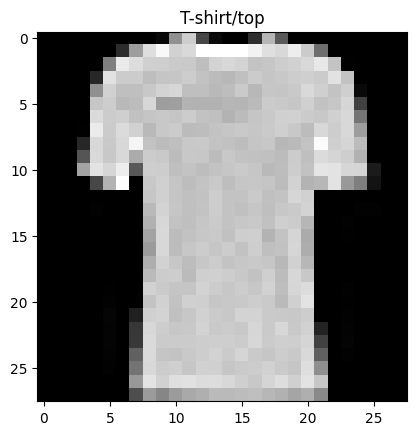

In [290]:
import random
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data),k=9):
    test_samples.append(sample)
    test_labels.append(label)



plt.imshow(test_samples[0].squeeze(), cmap='gray')
plt.title(class_names[test_labels[0]])

In [291]:
x = make_preds(model_2, test_samples)
print(x.shape) # will give (9,10).

# you NEED to argmax the dimension that corresponds to the number of feature labels (10)!!!!!
pred_labels = x.argmax(dim=1)

torch.Size([9, 10])


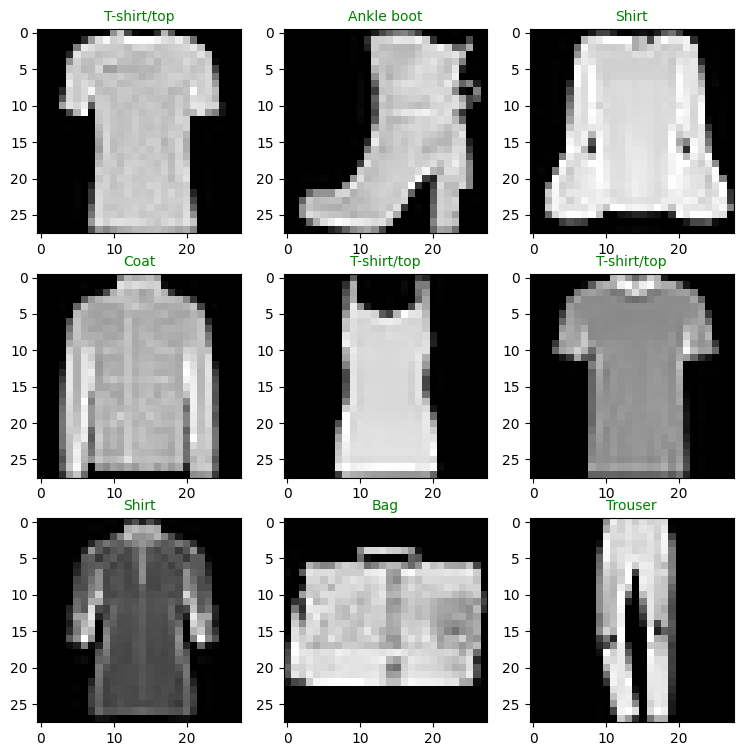

In [292]:
# Plot predictions
plt.figure(figsize=(9,9))
nrows, ncols = 3,3
for i, sample in enumerate(test_samples):
    plt.subplot(nrows,ncols, i+1)
    plt.imshow(sample.squeeze(), cmap='gray')
    pred_label = class_names[pred_labels[i]]
    true_label = class_names[test_labels[i]]

    title = f"Pred={pred_label} | True={true_label}"
    
    if pred_label==true_label:
        plt.title(pred_label, fontsize=10, c='g') # green color if true
    else:
        plt.title(title, fontsize=10, c='r') # green color if true


In [300]:
for X,y in test_dl:
    print(X.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 28, 28])
torch.Size([32, 1, 2

# A confusion matrix
A deeper way to visualise and evaluating model performance using a confusion matrix

1. Make predictions with trained model on the test dataset
2. Use `torchmetrics` to help us !
3. Plot the matrix using mlxtend

In [303]:
from torchmetrics import ConfusionMatrix
import mlxtend
from tqdm.auto import tqdm

y_preds=[]
model_2.eval()
with torch.inference_mode():
    for X,y in tqdm(test_dl, desc="inferring"):
        # send data to target device
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

inferring:   0%|          | 0/313 [00:00<?, ?it/s]

tensor([9, 2, 1,  ..., 8, 1, 2])

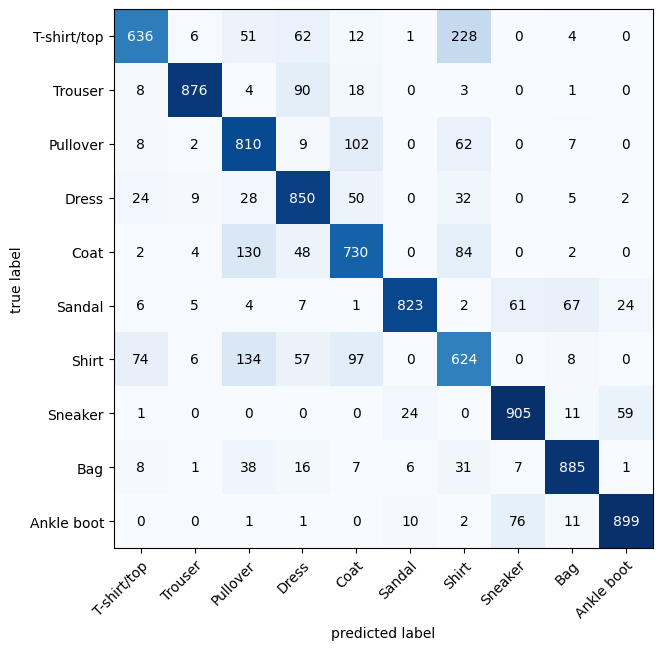

In [304]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)
)

# Save and load pytorch model

In [305]:
from pathlib import Path

# Create model path
MODEL_PATH = Path("model")
MODEL_PATH.mkdir(
    parents=True,
    exist_ok=True
)

# create save
MODEL_NAME = "03_pytorch_cv.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

torch.save(obj=model_2.state_dict(),
           f=MODEL_SAVE_PATH)

In [309]:
# Import in the model
torch.manual_seed(42)
loaded_model = FashionModel2(
    in_shape=1,out_shape=10,hidden_units=10
)
loaded_model.load_state_dict(
    torch.load(f=MODEL_SAVE_PATH)
)
loaded_model = loaded_model.to(DEVICE)

# Eval loaded model
loaded_res = eval_model(
    loaded_model,test_dl, loss_fn,accuracy_fn
)
loaded_res

  0%|          | 0/313 [00:00<?, ?it/s]

{'name': 'FashionModel2', 'loss': 0.32852885127067566, 'acc': 87.8594249201278}

In [310]:
# Check using torch.isclose
torch.isclose(torch.tensor(model_2_res["loss"]),
              torch.tensor(loaded_res["loss"]))

tensor(True)